In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

In [19]:
df = pd.read_csv(r"D:\Documents\University\DataAnalytics\Complete_Dataset_updated(in) (1).csv")

Create a Modular Plotting System Via Functions

In [20]:
def setupPlot(xsize, ysize, title, fontsize = 10, weight = 'bold', color = 'blue'):
    plt.figure(figsize=(xsize, ysize))
    plt.title(title, fontsize=fontsize, weight=weight, color=color)

def configureAxes(xlabel, ylabel, fontsize = 10, weight = 'bold', rotation = 0, ha = 'right'):
    plt.xlabel(xlabel, fontsize=fontsize, weight=weight)
    plt.ylabel(ylabel, fontsize=fontsize, weight=weight)
    plt.xticks(rotation=rotation, ha=ha)
#def addBar(Column, Color = 'Skyblue', x):
#    plt.bar(df[x], )
def addPlot(x, y, label, color = 'skyblue', marker = 'o', markersize = 10, linewidth = 2, linestyle = '-'):
    plt.plot(x, y, label=label, color=color, marker=marker, markersize=markersize, linewidth=linewidth, linestyle=linestyle)

def configureGrid(axis, linestyle, alpha):
    plt.grid(axis=axis, linestyle=linestyle, alpha=alpha)

def finalizePlot():
    plt.legend()
    plt.tight_layout()

Create functions to plot the Distribution and another function to calculate IQR

In [21]:
def plot_normal_distribution_and_test(feature):
    setupPlot(10,5, f"Distribution of {feature}")
    sns.histplot(df[feature], kde=True, stat="density", linewidth=0)
    configureAxes(feature, "Density")
    finalizePlot()
    plt.show()
'''def calculate_iqr(series):
    Q1 = np.percentile(series, 25)
    Q3 = np.percentile(series, 75)
    IQR = Q3 - Q1
    return IQR'''
def calculate_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3-Q1
    return IQR

------------------------------------------------------------

Quick Fixes and Quality of life things

In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['TEMP_MEAN'] = (df['TEMP_MAX'] + df['TEMP_MIN'] )/ 2
#df['AnimalsNumerical'] = pd.to_numeric(df['Animals'], errors='coerce')
#create biomass without animals

------------------------------------------------------------------------------------------------

Check for outliers

In [7]:
def FindOutliers(BisBoxPlot,BisVerical, Column):
    setupPlot(5,3, f"Check {Column} for Outliers")
    if(BisBoxPlot):
        if(BisVerical):
            sns.boxplot(y=df[Column])
        else:
            sns.boxplot(x=df[Column])
    else:
        if(BisVerical):
            sns.violinplot(y=df[Column])
        else:
            sns.violinplot(x=df[Column])
    finalizePlot()
    plt.show()

C:\Users\Yaman\AppData\Local\Temp\ipykernel_33452\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


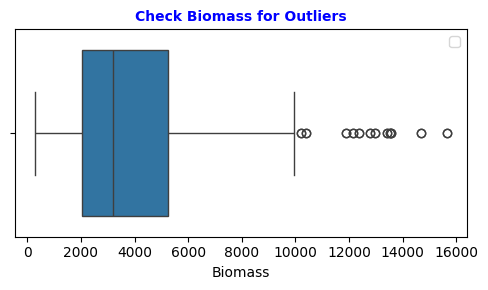

In [8]:
FindOutliers(True, False, 'Biomass')

In [8]:
def CalculateDispersion(column):
    range = df[column].max() - df[column].min()
    variance = df[column].var()
    std_dev = df[column].std()

    print('\n')
    print(f"The range of {column} is : ", range)
    print(f"The variance of {column} is : ", variance)
    print(f"The standard diviation of {column} is : ", std_dev)


Extract features to calculate via IQR or Z-Score

In [9]:
zscore_features = ['MM', 'ADF','B5']
iqr_features = [
    'Biomass','Lat', 'Long_', 'DM', 'NDF', 'CP', 'TDN_based_NDF',
    'NDVI', 'NDWI', 'EVI', 'LAI', 'DVI', 'GCI', 'GEMI',
    'SAVI', 'TEMP_MAX','TEMP_MEAN', 'TEMP_MIN', 'Rainfall', 'RAD_SOL', 'WIND_SPD', 'EVAPOT',
    'PRES_ATM', 'HUM_REL', 'TP_SFC_AVG', 'Wind_Dir', 'Dew_Point',
    'Radiative_Dif_AVG', 'Radiative_Direct_AVG', 'PPFD', 'Longwave_Rad_AVG',
    'Environmental Suitability Index','B1','B2','B3','B4','B6','B7','B8','B8A','B9','B11','B12', 'TDN_based_ADF'
]

Calculate Z-Score, and IQR

In [43]:
df_zScore = df[zscore_features].apply(zscore)
df_iqr = pd.DataFrame()
for feature in iqr_features:
    iqr = calculate_iqr(df[feature])
    df_iqr[feature] = (df[feature] - df[feature].median()).abs() / iqr
features_to_scale = zscore_features + iqr_features
groupdf = pd.concat([df['Date'], df_zScore, df_iqr], axis=1)  # Add Date back to the scaled dataframe
groupdf = groupdf.groupby('Date').mean().reset_index()
groupdf['Animals'] = df.groupby('Date')['Animals'].agg(lambda x: x.mode().iloc[0]).reset_index(drop=True)

Create a MinMaxScaler

In [12]:
#Must be changed for every column and Biomass individually
'''scaler = MinMaxScaler()
groupdf[features_to_scale] = scaler.fit_transform(groupdf[features_to_scale])'''

----------------------------------------------------------------------

Create a new Feature that categorizes biomass into 3 outputs: Low, Med, High

In [10]:
df['Biomass_Bins'] = pd.cut(df['Biomass'], bins=3, labels=['Low', 'Medium', 'High'], include_lowest=True)

Create a correlation Heatmap function

In [11]:
def createCorrelationImage(threshold):
    biomassCorrelation = df.select_dtypes(include='number').corr().loc[:,'Biomass']
    biomassCorrelation = biomassCorrelation[abs(biomassCorrelation)>=threshold]
    biomassCorrelation = biomassCorrelation.to_frame().T
    # Create the heatmap
    setupPlot(10,8, 'Correlation Matrix of Biomass Columns',16)
    sns.heatmap(biomassCorrelation, annot=True, cmap='coolwarm', fmt=".2f",
                annot_kws={'size': 12, 'weight': 'bold', 'color': 'black'},  # Custom annotation style
                linewidths=1, linecolor='gray', cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
                vmin=-1, vmax=1)
    configureAxes('Columns', 'Biomass',14)
    finalizePlot()
    plt.show()

Create a LinePlot graph for biomass and compare it with other columns

In [12]:
def createBiomassOverTime(DF, BisWithoutAnimals = True, BisBoth = False):
    WithNoAnimals = DF[DF['Animals'] == 0]
    WithAnimals = DF[DF['Animals'] == 1]
    if BisBoth:
        grouped_data = DF.groupby('Date')[['Biomass']].mean().reset_index()
    else:
        if BisWithoutAnimals:
            grouped_data = WithNoAnimals.groupby('Date')[['Biomass']].mean().reset_index()
        else:
            grouped_data = WithAnimals.groupby('Date')[['Biomass']].mean().reset_index()
    #scaler = MinMaxScaler()
    #grouped_data[['Biomass_scaled']] = scaler.fit_transform(grouped_data[[column1, column2]])

    plt.figure(figsize=(12, 6))
    setupPlot(12, 6, "Biomass Producion Over Time")
    addPlot(grouped_data['Date'], grouped_data['Biomass'], label='Biomass', color="blue")
    #plt.plot(grouped_data['Date'], grouped_data[f'{column1}_scaled'], label=f'{column1} (Scaled)', color=color1)
    #plt.plot(grouped_data['Date'], grouped_data[f'{column2}_scaled'], label=f'{column2} (Scaled)', color=color2)
    configureAxes('Date', 'Scaled Values',rotation=45)
    finalizePlot()
    plt.grid(True)
    plt.show()
def scale_and_plot(DF,column1, column2, title, color1='blue', color2='green',BisWithoutAnimals = True, BisBoth = False):
    WithNoAnimals = DF[DF['Animals'] == 0]
    WithAnimals = DF[DF['Animals'] == 1]
    if BisBoth:
        grouped_data = DF.groupby('Date')[[column1, column2]].mean().reset_index()
    else:
        if BisWithoutAnimals:
            grouped_data = WithNoAnimals.groupby('Date')[[column1, column2]].mean().reset_index()
        else:
            grouped_data = WithAnimals.groupby('Date')[[column1, column2]].mean().reset_index()
    scaler = MinMaxScaler()
    grouped_data[[f'{column1}_scaled', f'{column2}_scaled']] = scaler.fit_transform(grouped_data[[column1, column2]])

    plt.figure(figsize=(12, 6))
    setupPlot(12, 6, title)
    addPlot(grouped_data['Date'], grouped_data[f'{column1}_scaled'], label=f'{column1} Scaled', color=color1)
    addPlot(grouped_data['Date'], grouped_data[f'{column2}_scaled'], label=f'{column2} Scaled', color=color2)
    #plt.plot(grouped_data['Date'], grouped_data[f'{column1}_scaled'], label=f'{column1} (Scaled)', color=color1)
    #plt.plot(grouped_data['Date'], grouped_data[f'{column2}_scaled'], label=f'{column2} (Scaled)', color=color2)
    configureAxes('Date', 'Scaled Values',rotation=45)
    finalizePlot()
    plt.grid(True)
    plt.show()

'''features = df.columns.tolist()
features = df.drop(columns=['Sample_type', 'Animals', 'Sample', 'Sub-Sample', 'Lat', 'Long_',
                            'DOY', 'Satellite_Images_Dates','AnimalsNumerical','Date'], axis = 1)'''

"features = df.columns.tolist()\nfeatures = df.drop(columns=['Sample_type', 'Animals', 'Sample', 'Sub-Sample', 'Lat', 'Long_',\n                            'DOY', 'Satellite_Images_Dates','AnimalsNumerical','Date'], axis = 1)"

-----------------------------------------------------------------------------

Create a map for sample locations

In [13]:
def createMap(Column,Title, label, xlabel, DF):
    setupPlot(xsize=12, ysize=8, title=Title, fontsize=12, weight='bold', color='skyblue')
    configureAxes(xlabel=xlabel, ylabel=label, fontsize=12, weight='bold', rotation=45, ha='right')
    bubble_chart = sns.scatterplot(x='Long_', y='Lat', size=Column, sizes=(20, 200), hue=Column, palette='viridis', data=DF, legend=False, alpha=0.6)
    configureGrid(axis='y', linestyle='--', alpha=0.7)
    finalizePlot()
    plt.show()
def create2Map(Column, Column2,Title, Color, label, xlabel, DF):
    setupPlot(xsize=12, ysize=8, title=Title, fontsize=12, weight='bold', color='skyblue')
    configureAxes(xlabel=xlabel, ylabel=label, fontsize=12, weight='bold', rotation=45, ha='right')
    bubble_chart = sns.scatterplot(x='Long_', y='Lat', size=Column, sizes=(20, 200), hue=Column, palette='viridis', data=DF, legend=False, alpha=0.6)
    bubble_chart = sns.scatterplot(x='Long_', y='Lat', size=Column2, sizes=(20, 200), hue=Column, palette='magma', data=DF, legend=False, alpha=0.6)
    configureGrid(axis='y', linestyle='--', alpha=0.7)
    finalizePlot()
    plt.show()

Function to plot a pie chart to compare percentage of samples with and without animals

In [14]:
def plot_animal_percentage(df):
    animal_counts = df['Animals'].value_counts()
    setupPlot(8,6,'Percentage of Samples with and Without Animals')
    plt.pie(animal_counts, labels=['Sample of data With Animals', 'Sample of data Without Animals (1)'], autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    finalizePlot()
    plt.show()

Create a contingency table with a heatmap to visualize it

In [15]:
def create_contingency_table(df, column1, column2):
    contingency_table = pd.crosstab(df[column1], df[column2])
    setupPlot(xsize=12, ysize=8, title=f'Contingency Table: {column1} vs. {column2}', fontsize=12, weight='bold', color='skyblue')
    configureAxes(xlabel=column1, ylabel=column2, fontsize=12, weight='bold', rotation=0, ha='right')
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="viridis", label=['With Animals', 'Without Animals'])
    return contingency_table

In [16]:
def BoxPlotForAnimals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    plt.suptitle('Biomass Analysis with Animals', fontsize=12, weight='bold')

    # First subplot - Box plot
    sns.boxplot(x='Animals', y='Biomass', data=df, palette='viridis', ax=ax1)
    ax1.set_title('Distribution of Biomass between Animals and without Animals')
    ax1.set_xlabel('Animals')
    ax1.set_ylabel('Biomass')

    # Second subplot - Outliers
    sns.boxplot(y=df['Biomass'], ax=ax2)
    ax2.set_title('Biomass Outliers')
    ax2.set_xlabel('Biomass')

    plt.tight_layout()
    plt.show()

#BoxPlotForAnimals()

Create Sample type distribution

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


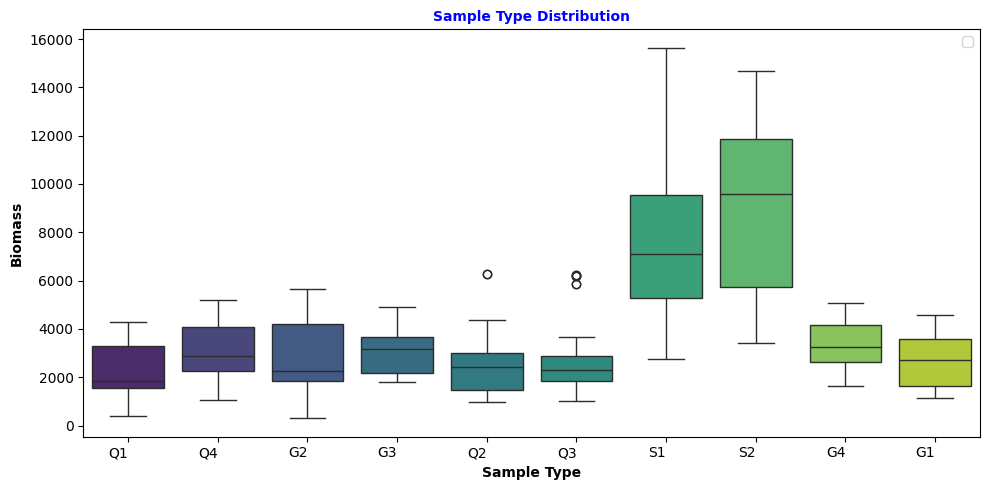

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


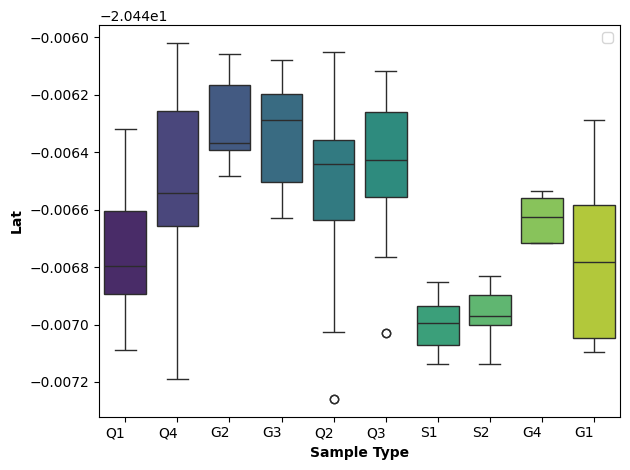

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


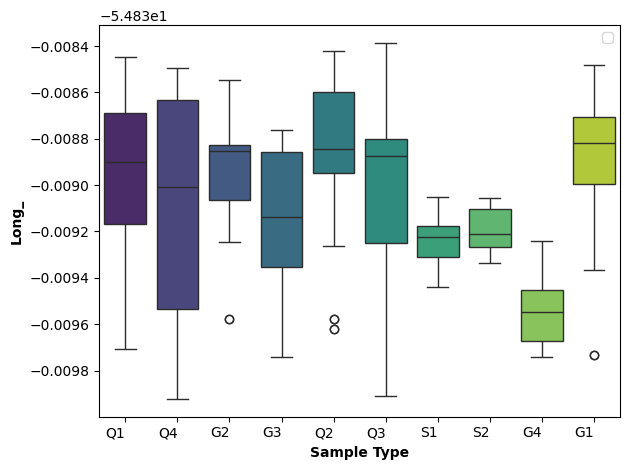

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


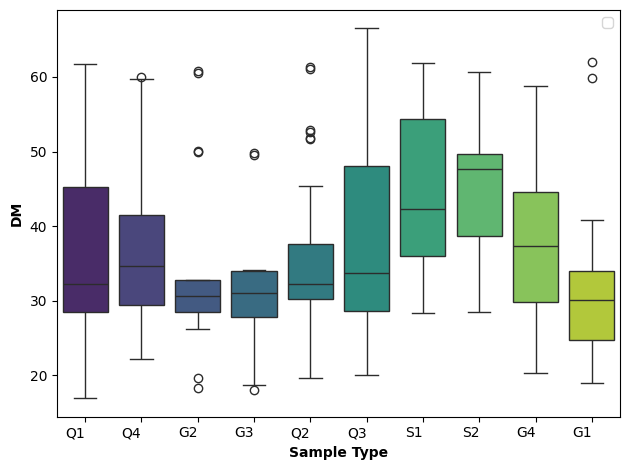

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


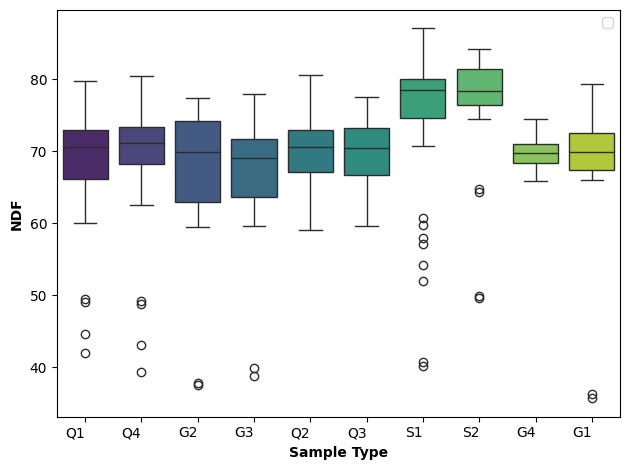

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


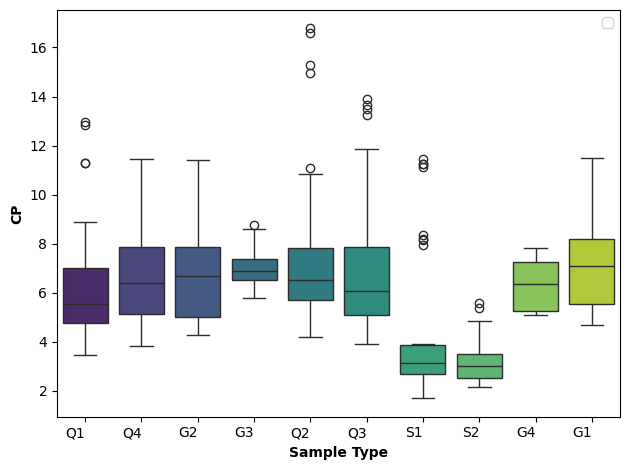

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


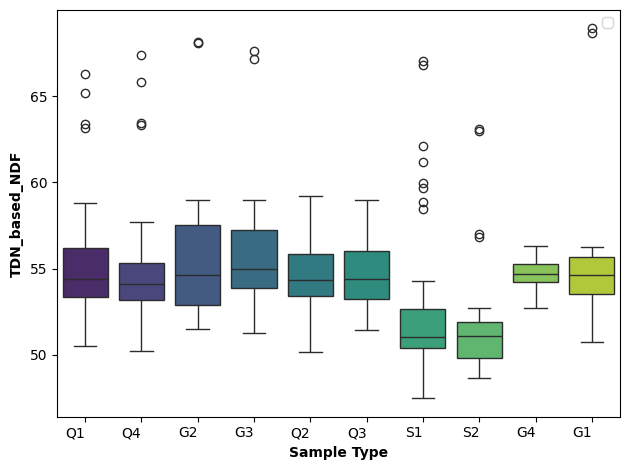

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


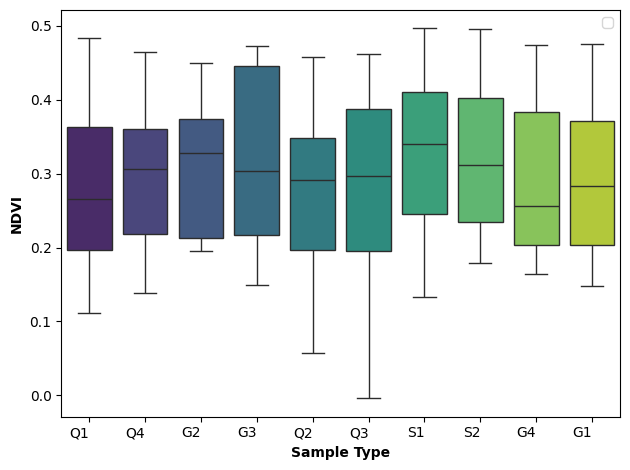

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


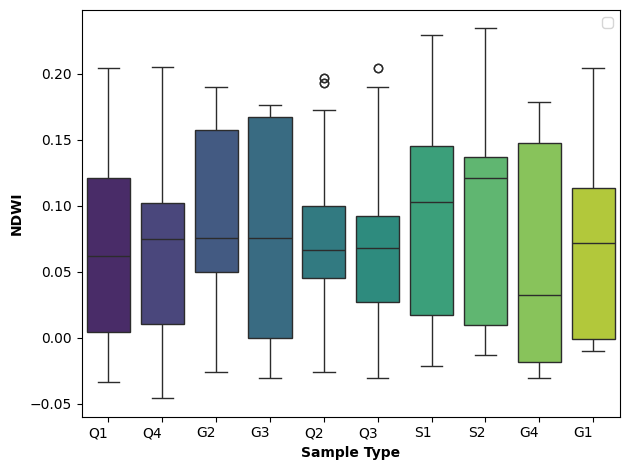

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


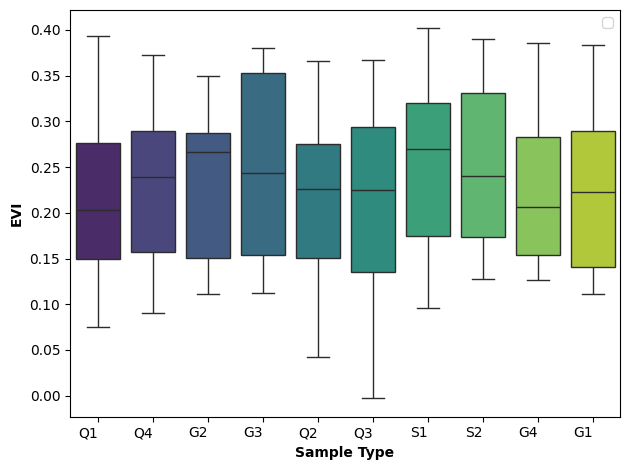

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


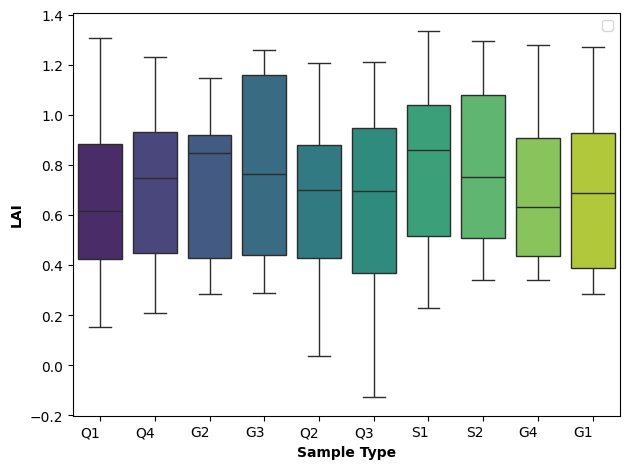

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


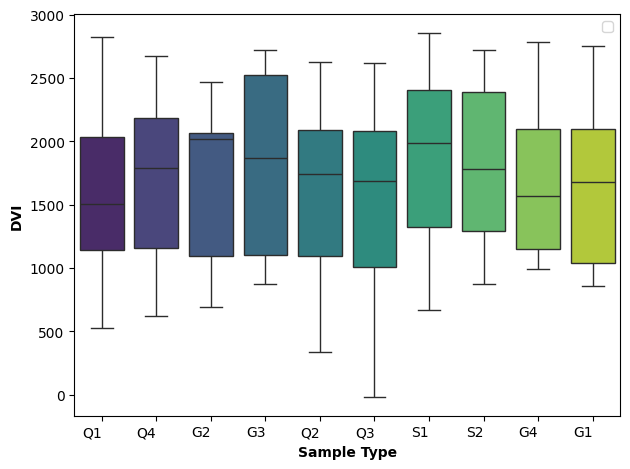

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


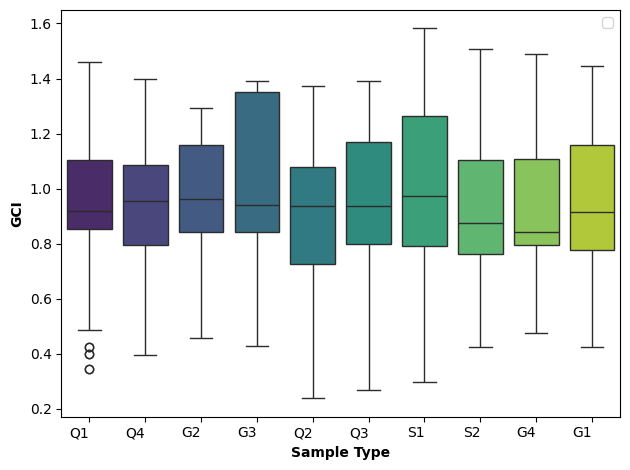

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


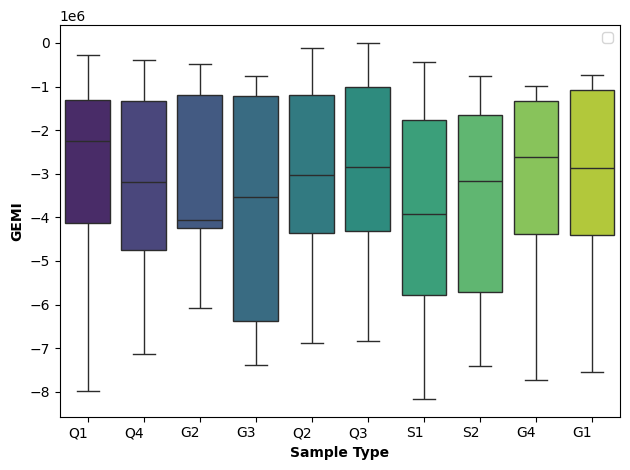

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


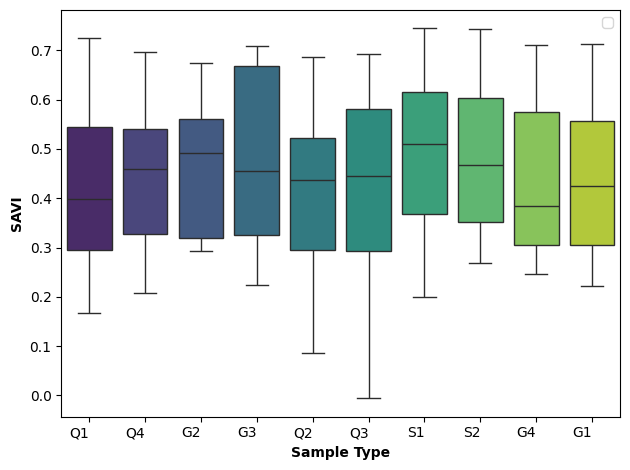

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


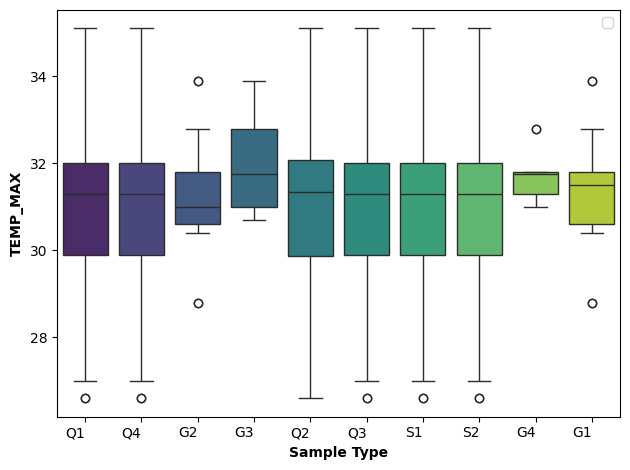

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


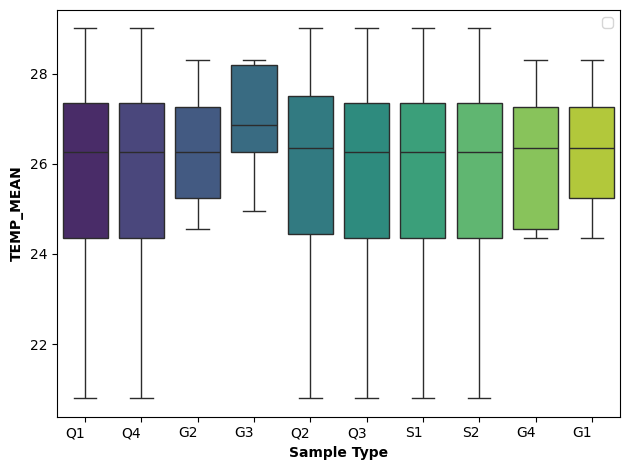

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


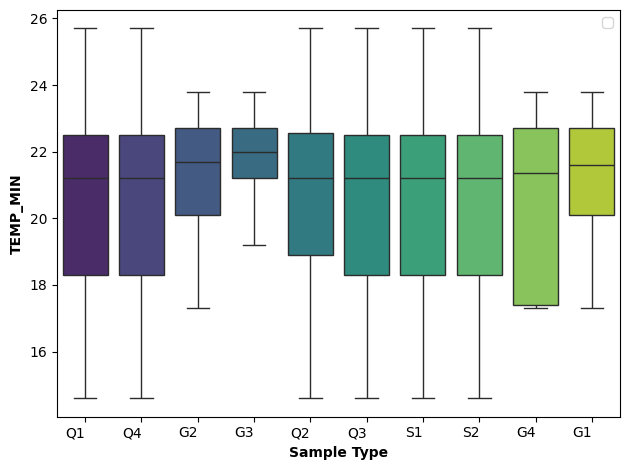

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


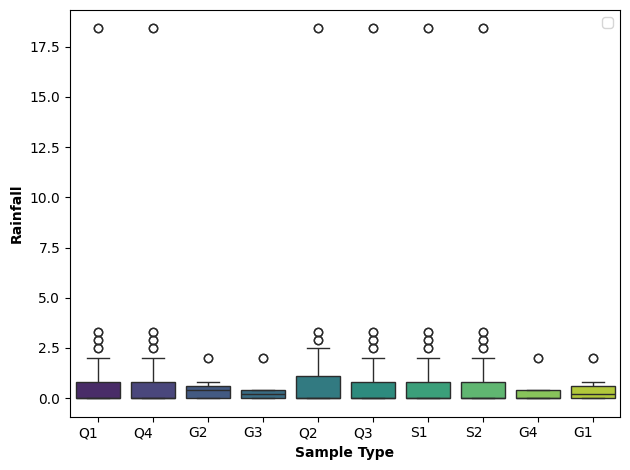

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


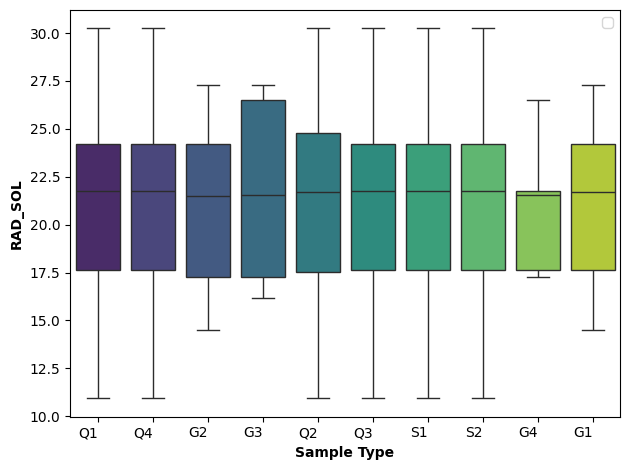

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


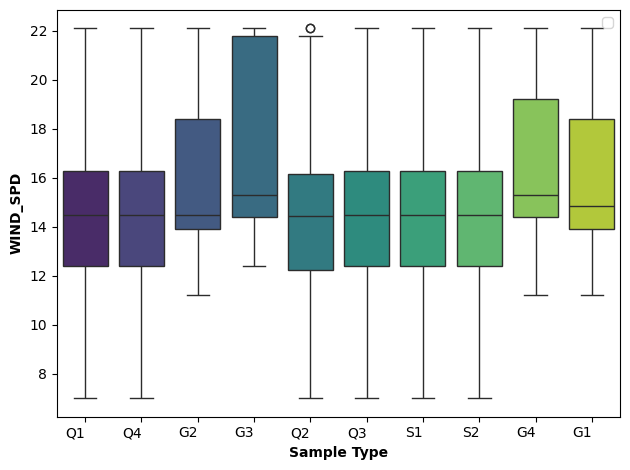

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


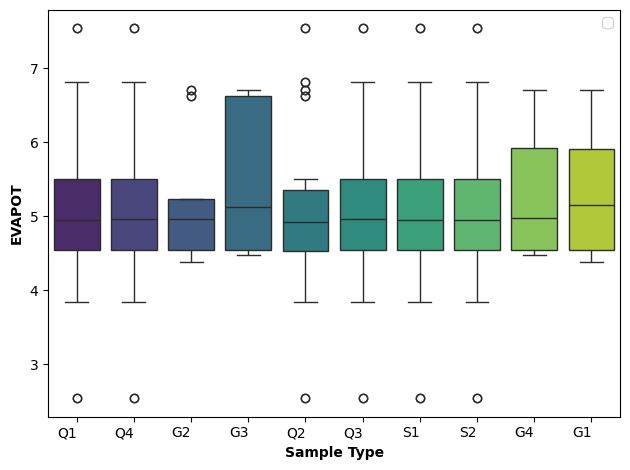

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


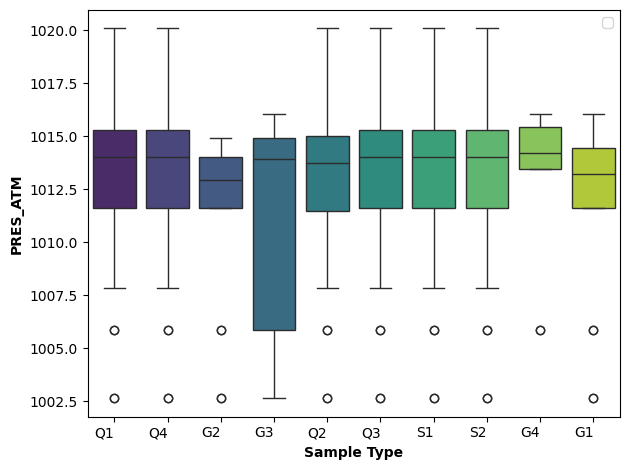

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


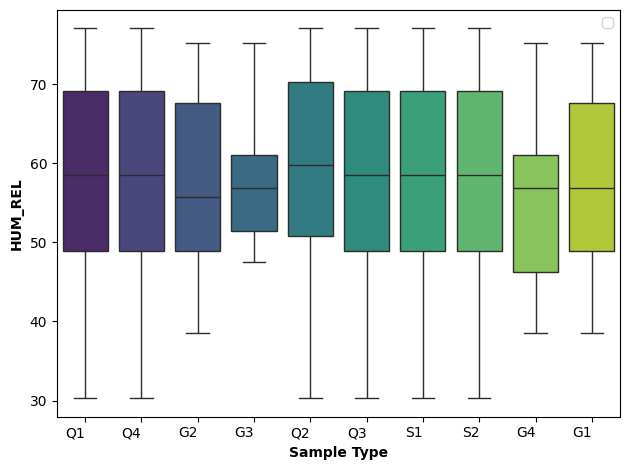

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


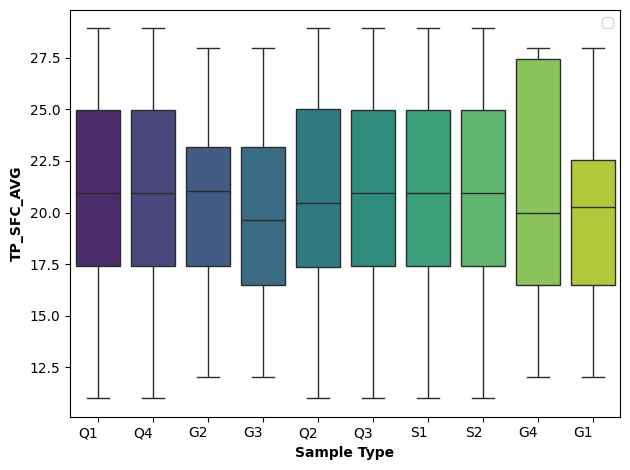

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


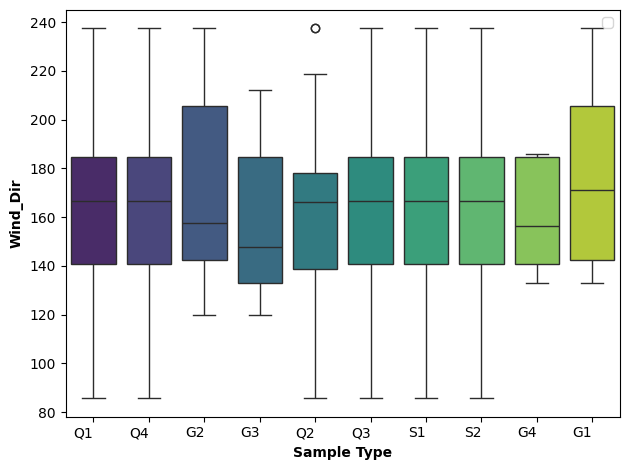

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


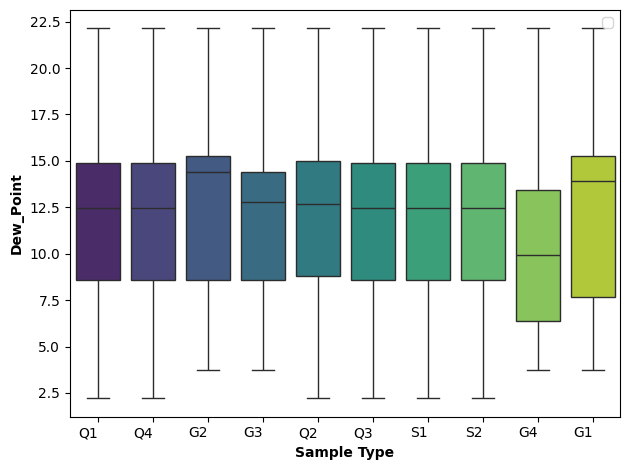

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


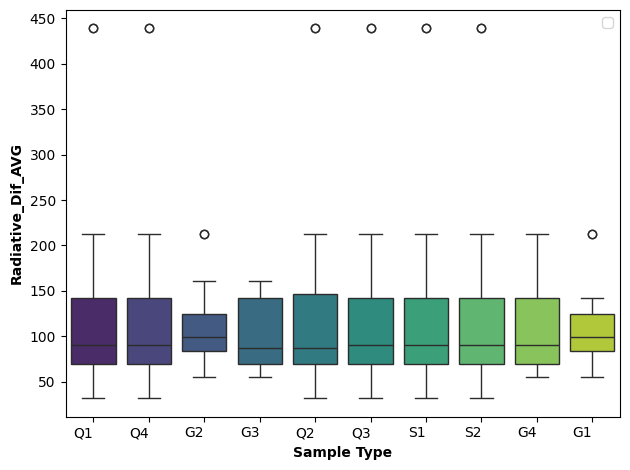

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


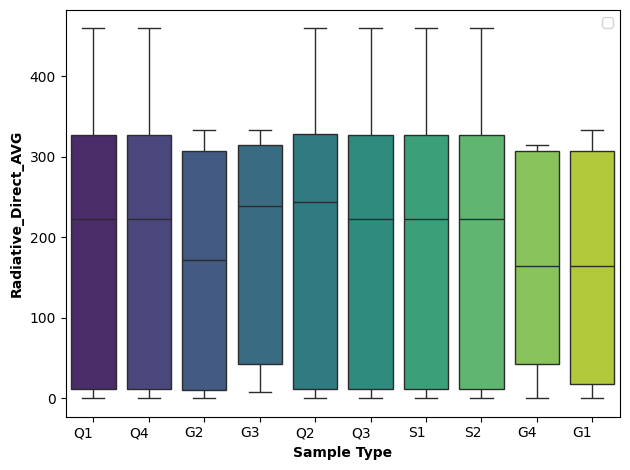

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


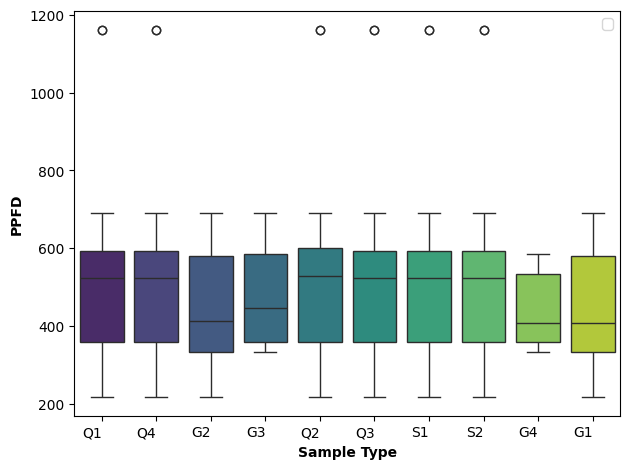

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


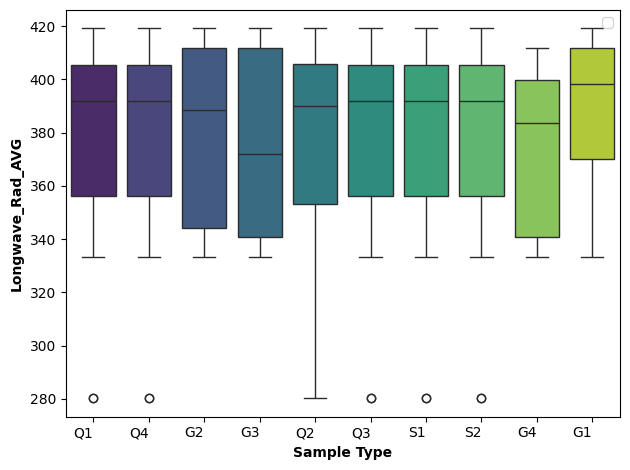

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


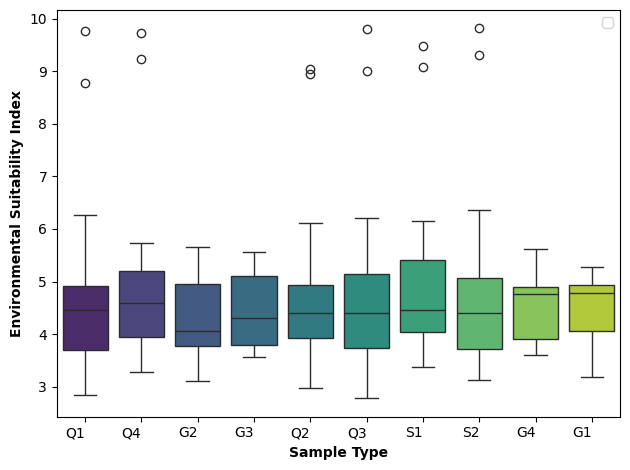

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


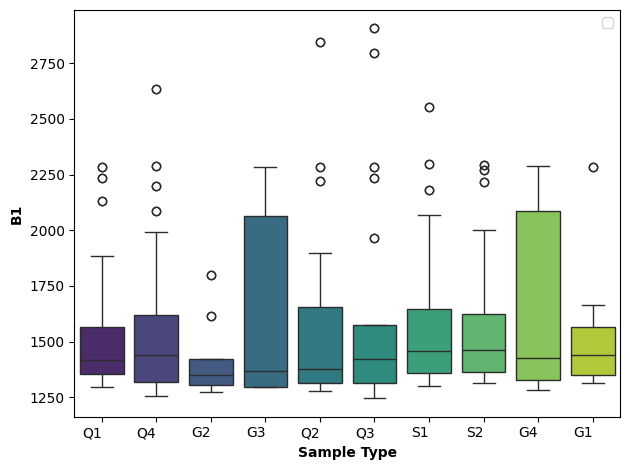

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


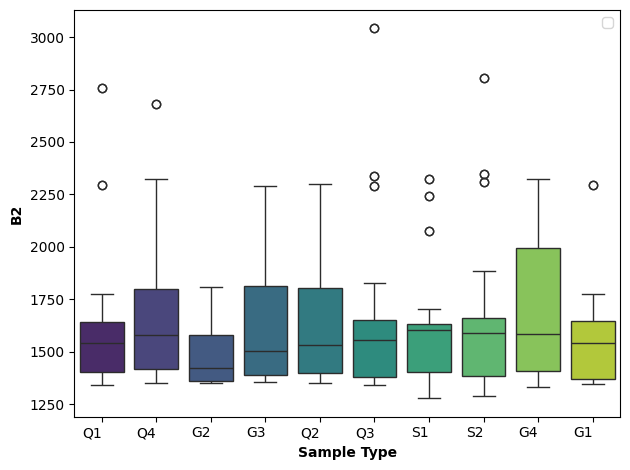

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


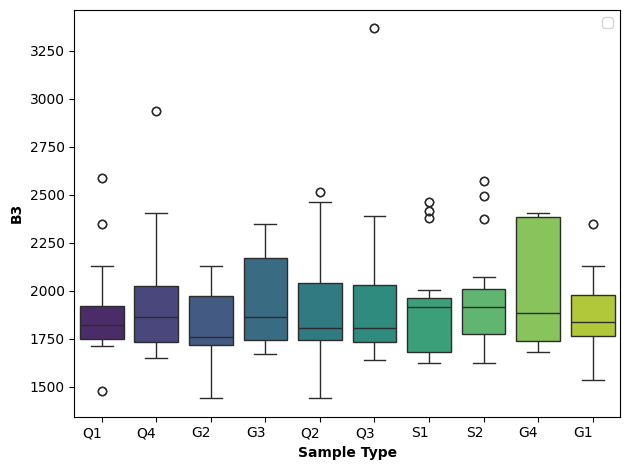

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


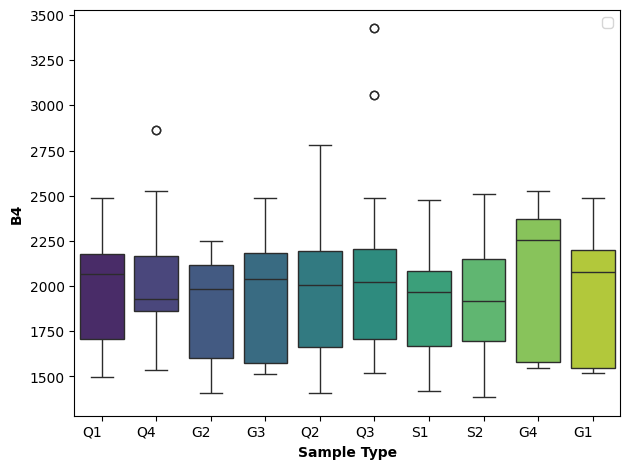

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


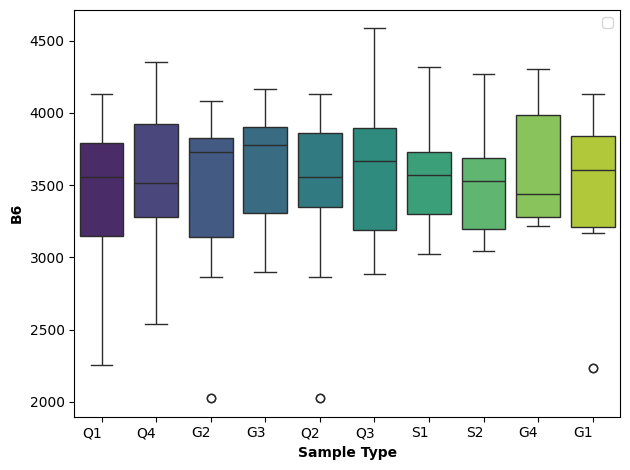

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


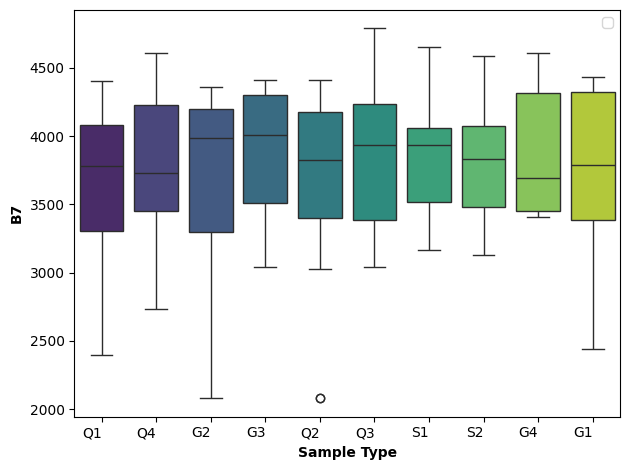

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


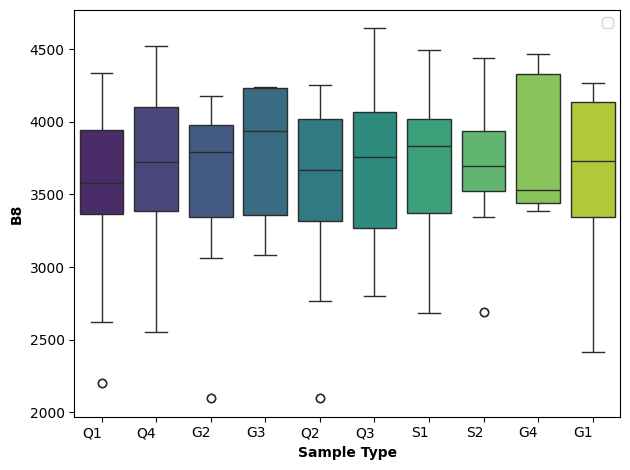

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


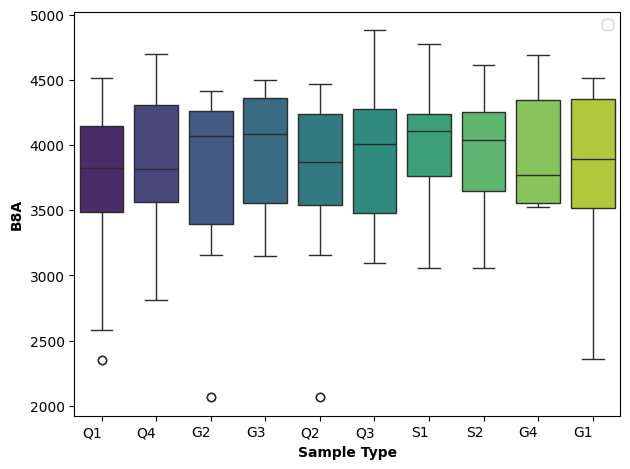

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


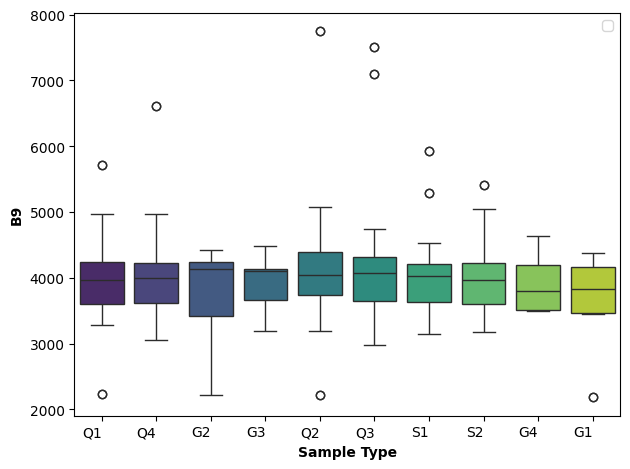

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


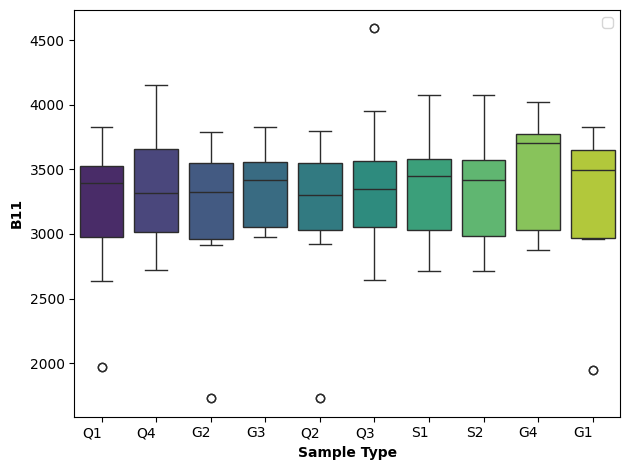

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


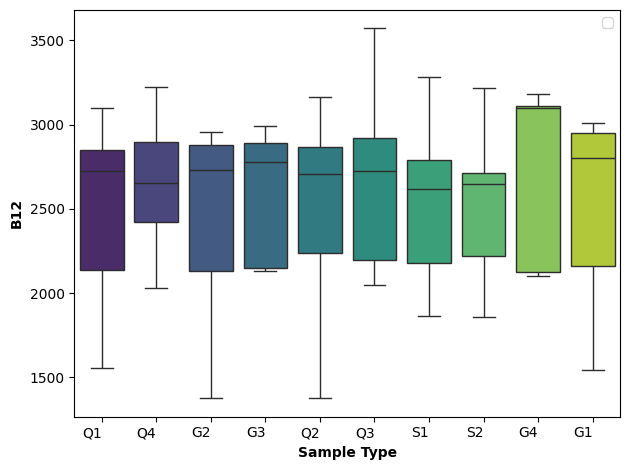

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


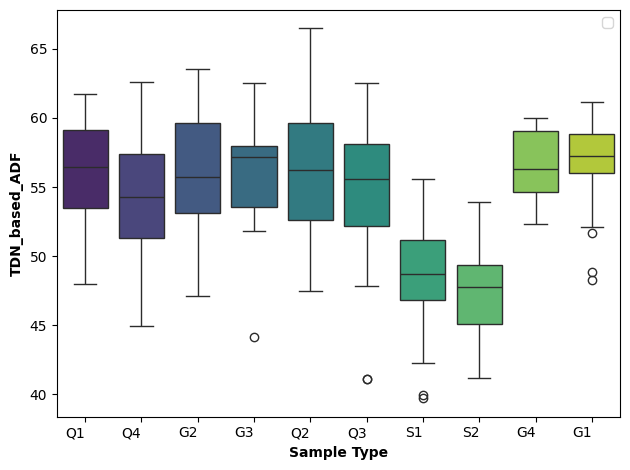

In [17]:
colors = plt.cm.tab20b.colors

def plotSampleTypeDistribution():
    plt.figure(figsize=(12, 8))
    setupPlot(10, 5, 'Sample Type Distribution')
    plt.bar(df['Sample_type'].value_counts().index, df['Sample_type'].value_counts().values, color = colors)
    #sns.countplot(data=df, x='Sample_type', palette='viridis')
    plt.tight_layout()
    plt.show()
def plotBiomassSampleCount():
    setupPlot(10, 5, 'BiomassS Sample Count Distribution')
    BiomassBar_df = df.groupby('Sample_type')['Biomass'].mean().reset_index()
    #BiomassBar_df.plot(kind='bar', color=colors)
    sns.barplot(data=BiomassBar_df, x='Sample_type', y='Biomass', palette='viridis')
    configureAxes('Sample Type', 'Biomass Size')
    finalizePlot()
    plt.show()
def sampleBoxPlot():
    setupPlot(10, 5, 'Sample Type Distribution')
    sns.boxplot(data=df, x='Sample_type', y='Biomass', palette='viridis')
    configureAxes('Sample Type', 'Biomass')
    finalizePlot()
    plt.show()
def createSampleTypeMap():
    setupPlot(xsize=12, ysize=8, title='Sample Locations by Type', fontsize=12, weight='bold', color='skyblue')
    sns.scatterplot(data=df, x='Long_', y='Lat', hue='Sample_type', s=100)
    configureAxes('Longitude', 'Latitude', fontsize=12, weight='bold', rotation=0, ha='right')
    finalizePlot()
    plt.show()
def createSampleVisualization():
    plotSampleTypeDistribution()
    plotBiomassSampleCount()
    sampleBoxPlot()
    createSampleTypeMap()

def LoopsampleBoxPlot():
    setupPlot(10, 5, 'Sample Type Distribution')
    for feature in iqr_features:
        sns.boxplot(data=df, x='Sample_type', y=feature, palette='viridis')
        configureAxes('Sample Type', feature)
        finalizePlot()
        plt.show()
    #sns.boxplot(data=df, x='Sample_type', y='Biomass', palette='viridis')
    #configureAxes('Sample Type', 'Biomass')
    #finalizePlot()
    #plt.show()
LoopsampleBoxPlot()


------------------------------------------------------------------------------------------------

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\2243270676.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Animals', y='Biomass', data=df, palette='viridis', ax=ax1)


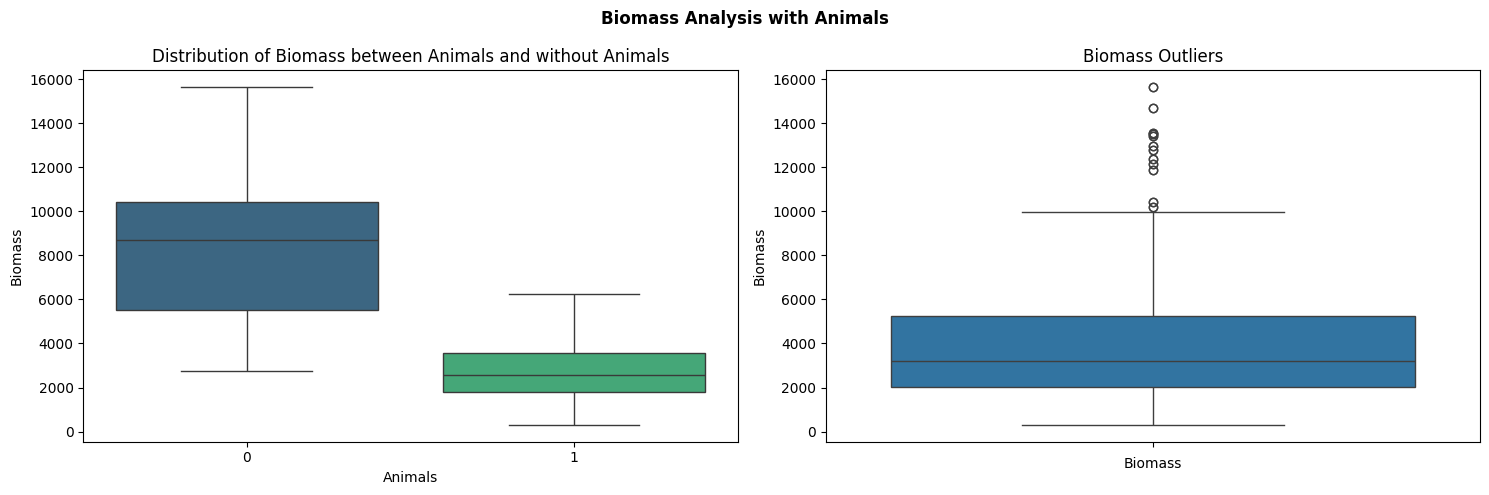

<Figure size 1200x800 with 0 Axes>

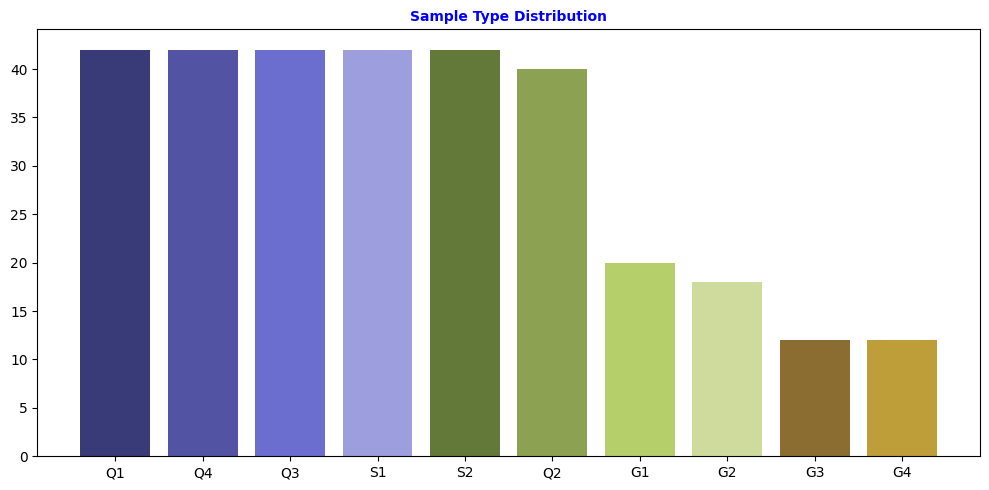

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=BiomassBar_df, x='Sample_type', y='Biomass', palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


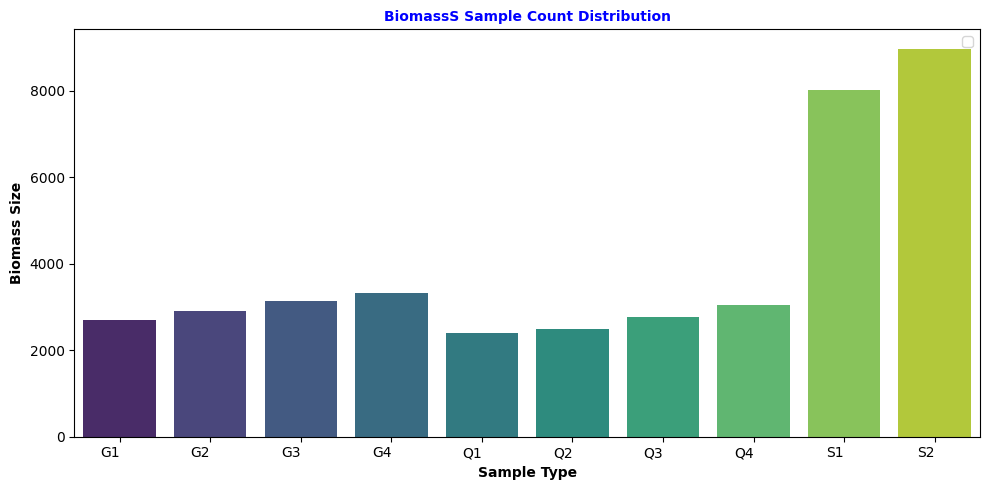

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1596496531.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sample_type', y='Biomass', palette='viridis')
C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


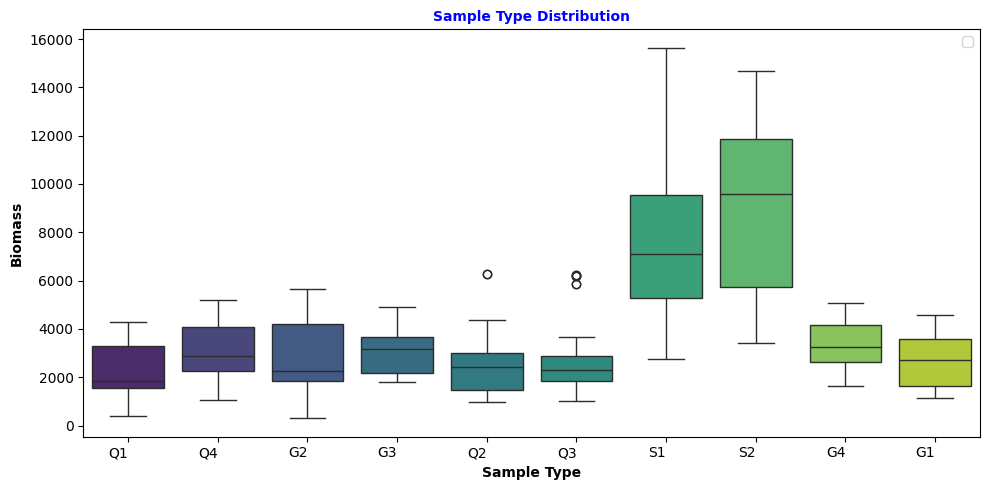

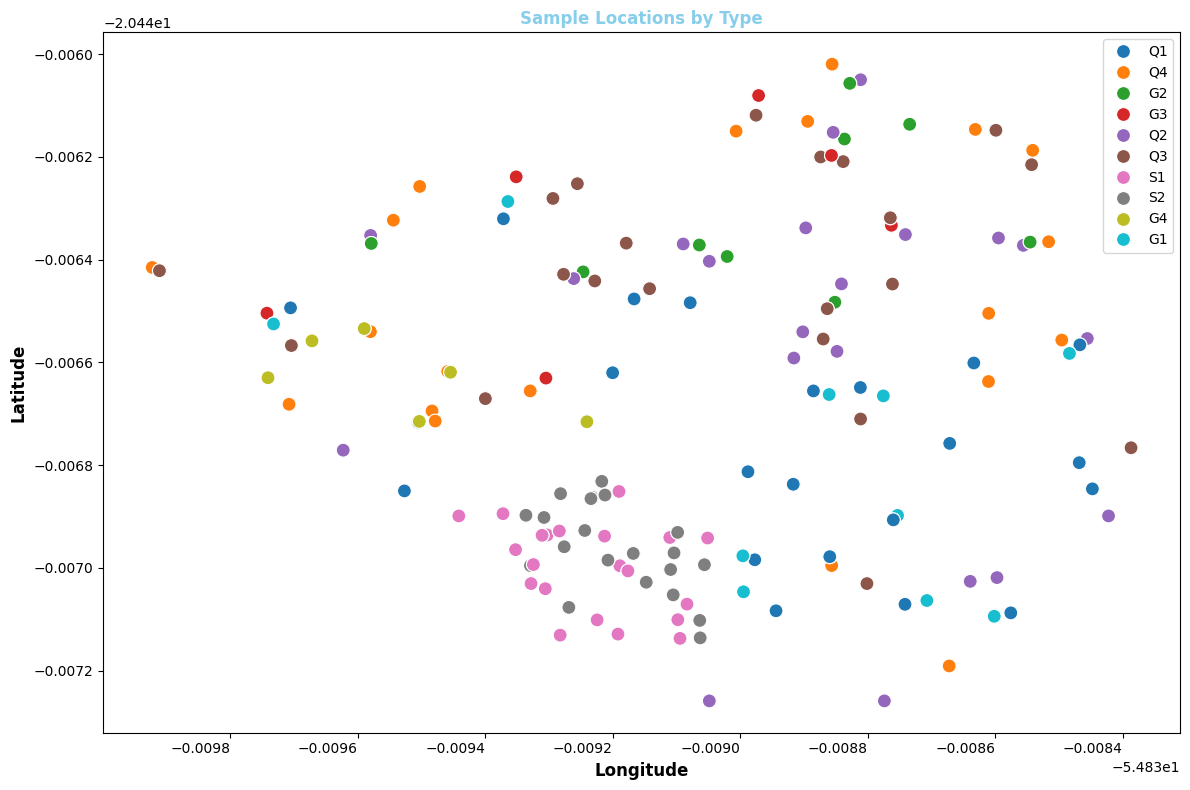

C:\Users\Yaman\AppData\Local\Temp\ipykernel_19684\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


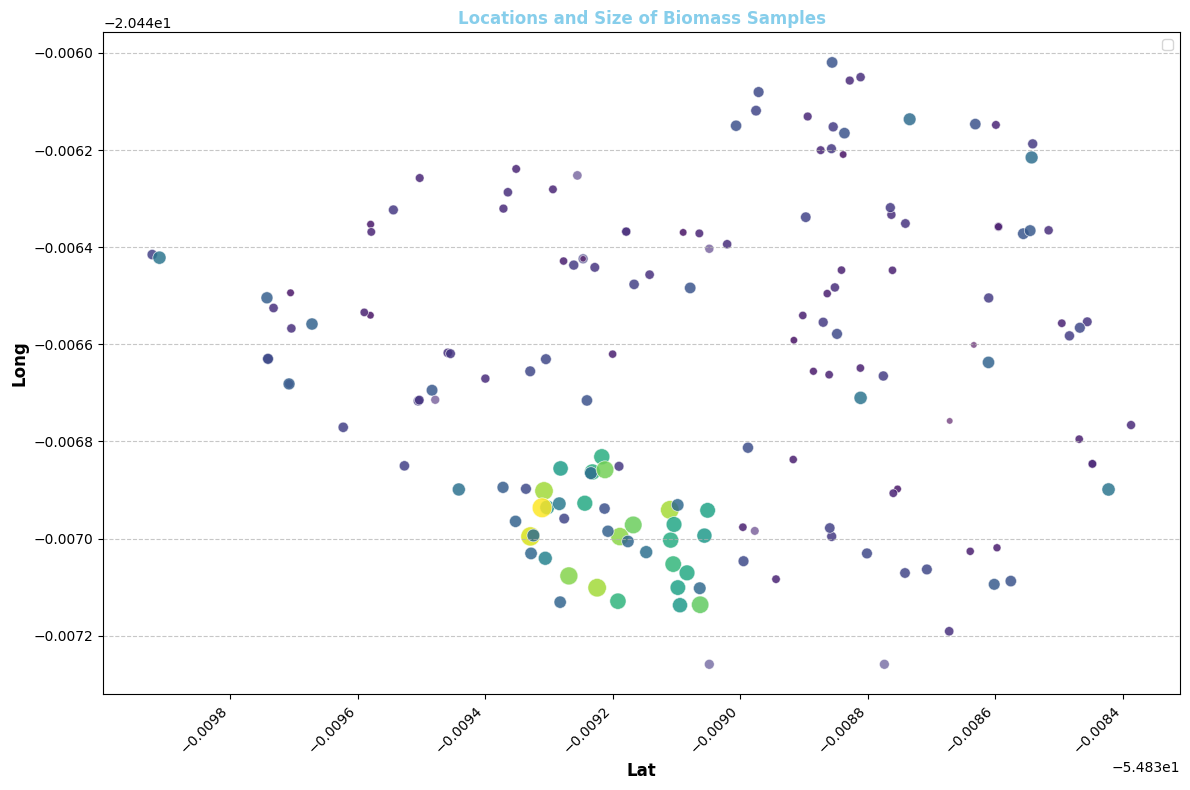

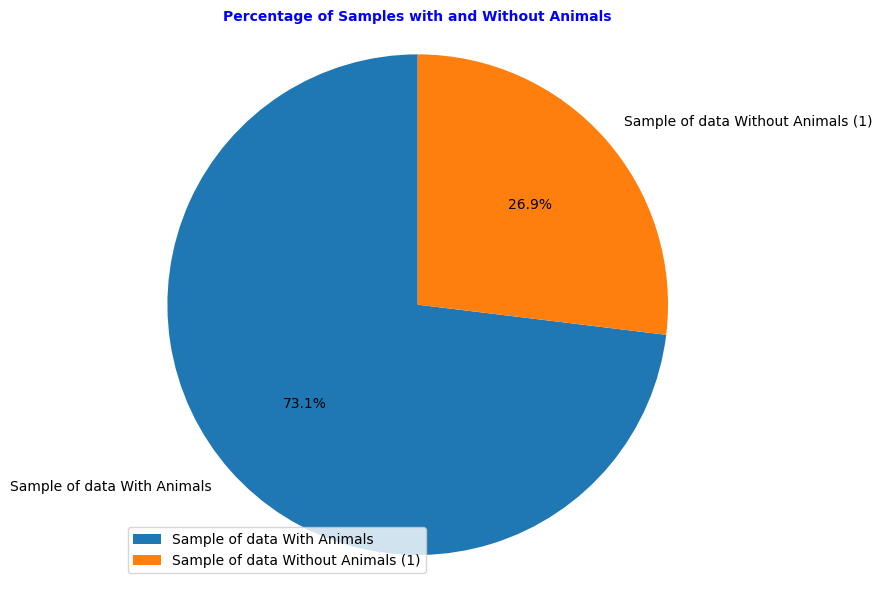

In [22]:
BoxPlotForAnimals()
createSampleVisualization()
createMap('Biomass','Locations and Size of Biomass Samples', 'Long', 'Lat', df)
plot_animal_percentage(df)

Datasets has little to no outliers and they do not stem from any technical issue that I know off, they are accurate observations. For the biomass specifically it is noted that we have 2 pastures, one with animals and one without, the without one have a much more higher biomass weight on average than the pasture with animals. And its wrong to look at the biomass as just one continous samples, they must be seperated by the pasture they were taken from as if not done, the values from pasture without animals will be seen as outliers because not alot of samples were taken from it.

As seen here, when trying to find outliers for biomass with and without animals, we find none. But when trying to find outliers for biomass without taking into account the animals we see that there are outliers

Animals,0,1
Biomass_Bins,,
Low,20,218
Medium,44,10
High,20,0


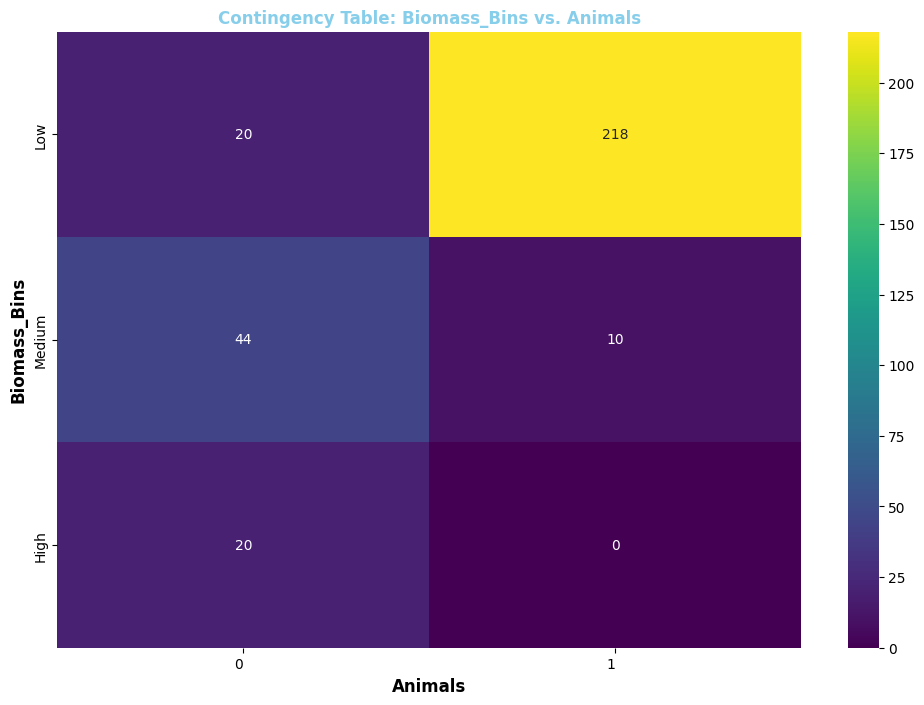

In [92]:
create_contingency_table(df, 'Biomass_Bins', 'Animals')

In [26]:
features = ['DM', 'TDN_based_ADF', 'NDWI', 'GEMI','Biomass']

for feature in features:
    CalculateDispersion(feature) 




The range of DM is :  49.55726792
The variance of DM is :  134.7535435954743
The standard diviation of DM is :  11.608339398702741


The range of TDN_based_ADF is :  26.750775149999996
The variance of TDN_based_ADF is :  28.629259740264107
The standard diviation of TDN_based_ADF is :  5.3506317141309685


The range of NDWI is :  0.280377638
The variance of NDWI is :  0.005085496156383324
The standard diviation of NDWI is :  0.07131266476849203


The range of GEMI is :  8164044.9527217
The variance of GEMI is :  4390253835198.505
The standard diviation of GEMI is :  2095293.2575652758


The range of Biomass is :  15328.8000033
The variance of Biomass is :  10758326.040724695
The standard diviation of Biomass is :  3279.9887257008513


DM values vary significantly, high standard deviation means that DM are really spread apart over a large time period.

TDN_based_ADF values have medium/moderate range and std, which means that the values are not really that much spread out like DM

NDWI values have a small range and a low std meaning that the values are clustered around the mean

GEMI values have an extremely insane range and a very very very high std meaning that the values are really spread apart

Biomass values have a large range and STD meaning that there is a significant variability in the biomass measurements.

C:\Users\Yaman\AppData\Local\Temp\ipykernel_24144\1888442615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


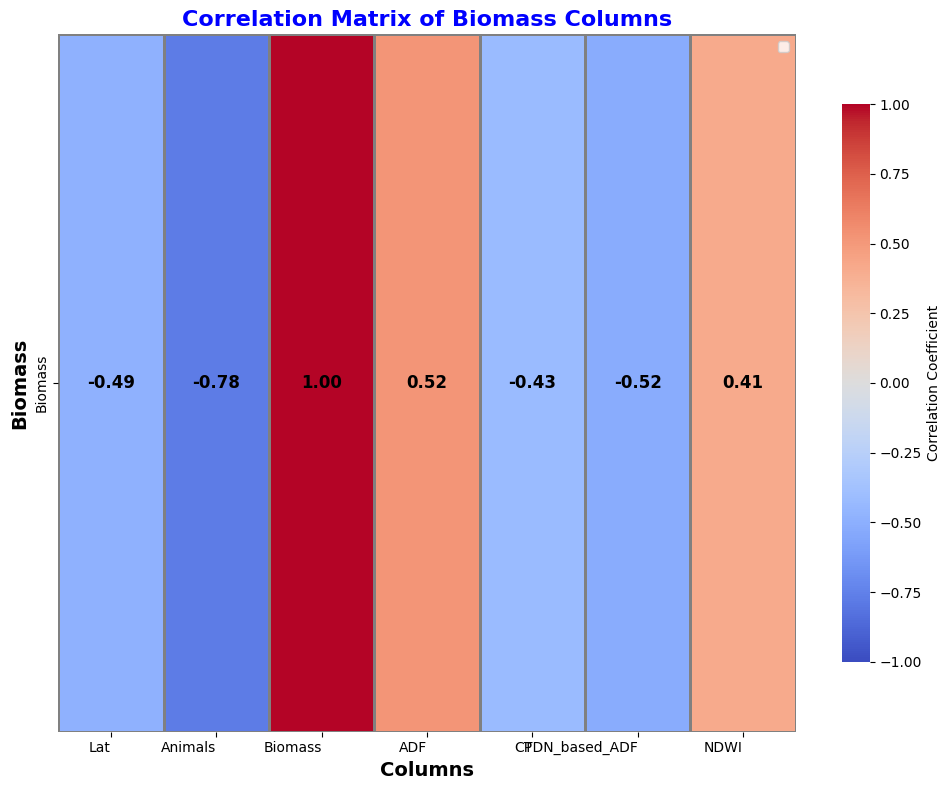

In [27]:
createCorrelationImage(.4)

Correlation heatmap only solidifies what we know which is that animals have a negative relationship with the biomass, but other relations are shown to be complex and non-linear

<Figure size 1200x600 with 0 Axes>

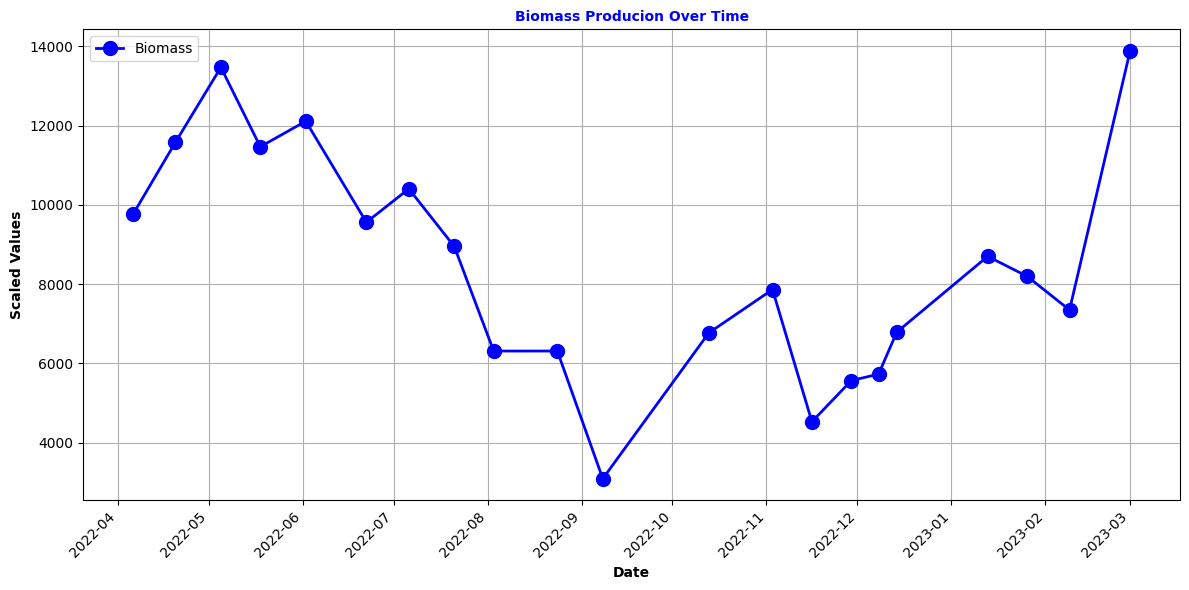

In [28]:
createBiomassOverTime(df, BisWithoutAnimals=True, BisBoth=False)


<Figure size 1200x600 with 0 Axes>

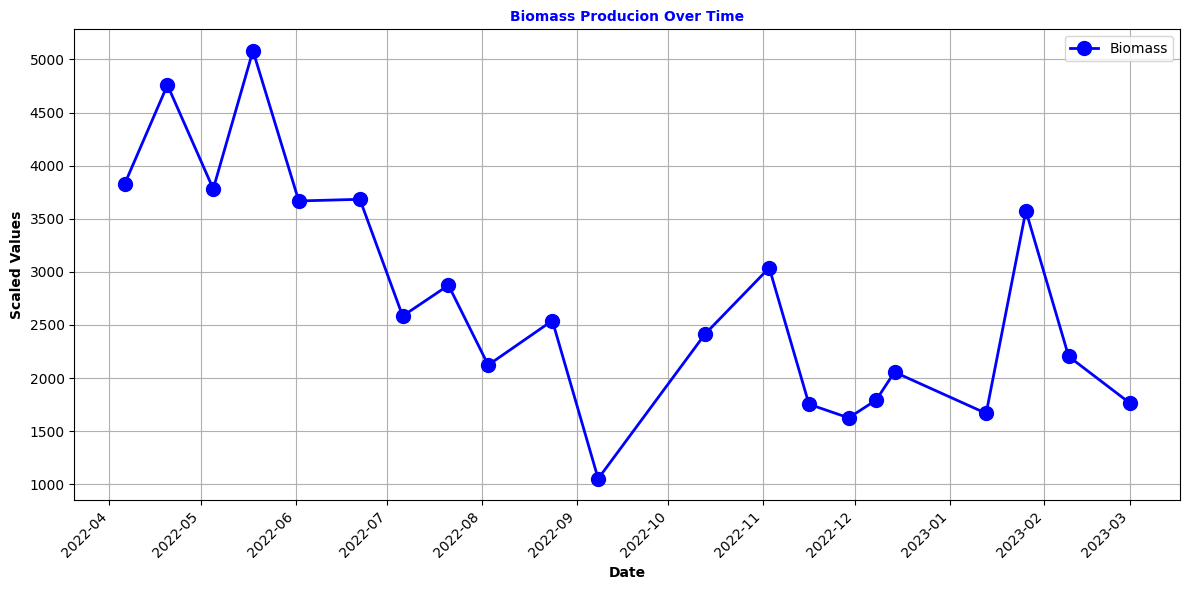

In [22]:
createBiomassOverTime(df, BisWithoutAnimals=False, BisBoth=False)

<Figure size 1200x600 with 0 Axes>

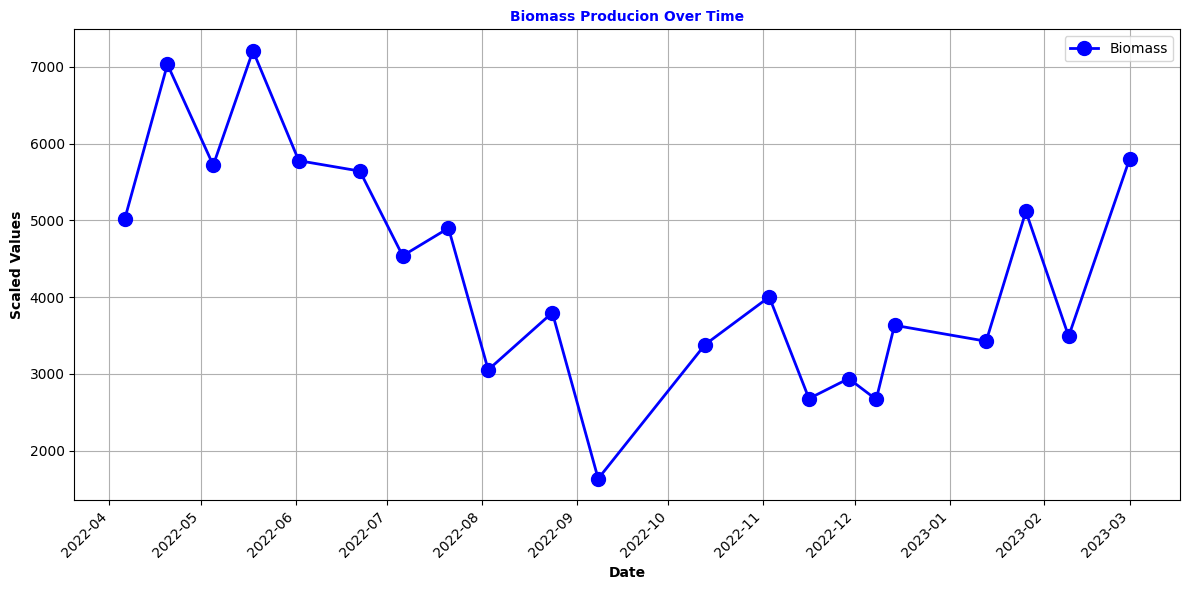

In [23]:
createBiomassOverTime(df, BisWithoutAnimals=False, BisBoth=True)

Biomass production overtime, one with animals and one without, and one combining them both

<Figure size 1200x600 with 0 Axes>

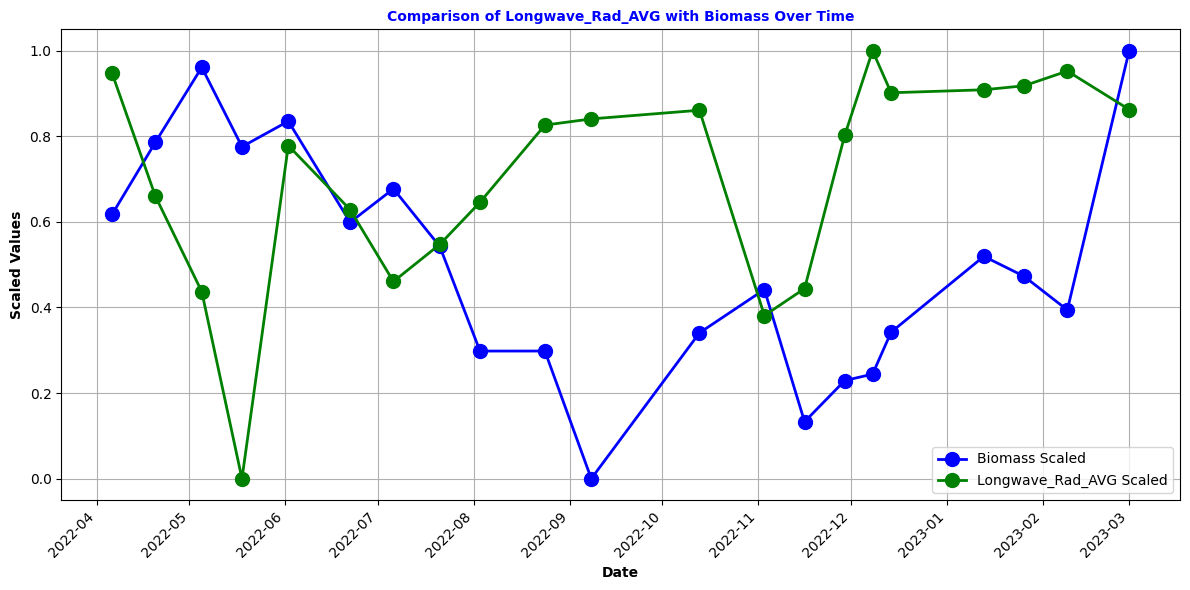

In [95]:
scale_and_plot(df, 'Biomass', 'Longwave_Rad_AVG', f'Comparison of Longwave_Rad_AVG with Biomass Over Time', BisWithoutAnimals=True, BisBoth=False)

As seen in this image, The biomass shows a clear seasonal pattern, increasing from the spring to late summer, and then declining through the winter. And at first glance, you will find that the Longwave_Rad_AVG follows the biomass somewhat, but then the biomass drops and the longwave radiation increases and thus the relationship turns negative. 

Significant Correlation between Longwave_RAD_AVG and biomass:
Longwave Radiation and Plant Growth: 

<Figure size 1200x600 with 0 Axes>

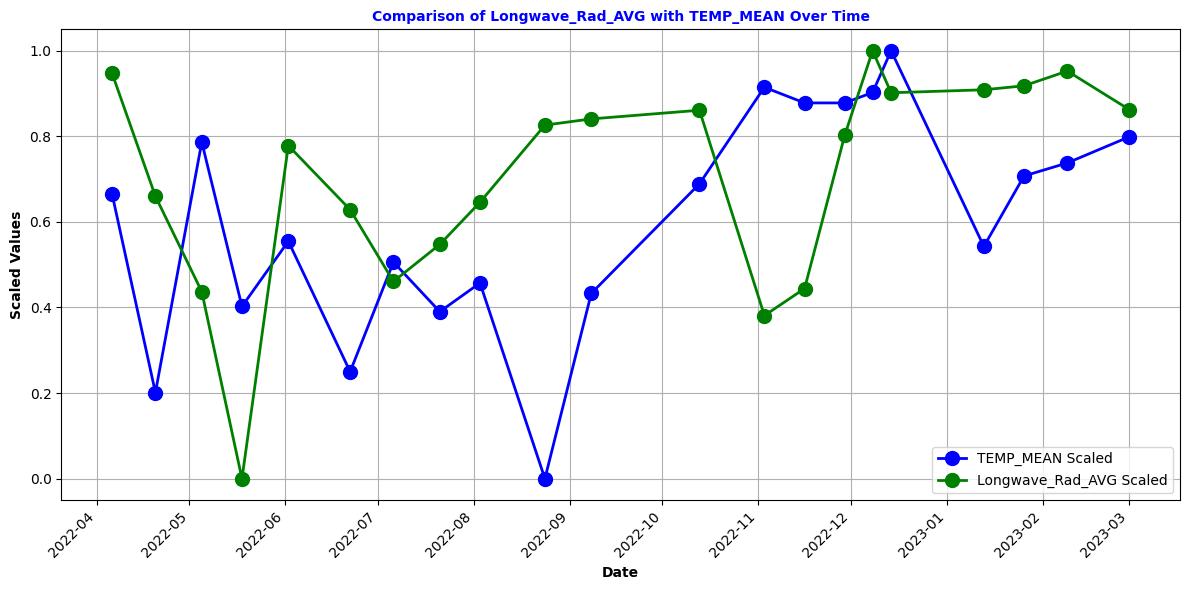

In [120]:
scale_and_plot(df,'TEMP_MEAN', 'Longwave_Rad_AVG', f'Comparison of Longwave_Rad_AVG with TEMP_MEAN Over Time', BisWithoutAnimals=False, BisBoth=True)

And then looking at this image which compares the avg temperature to the longwave radiation, its shown that the temperature dropped significantly but the longwave radiation didn’t, this could because of the fact that the longwave radiation is measured from the radiation from the earth’s surface. Meaning that even though the air is cold, the ground is still warm. And then returning to our original plot, Biomass vs Longwave_Rad_AVG, in the fall, there is a higher temperature and a high longwave radiation, but the plants could’ve completed their growth cycles, and thus the biomass becomes lower.

<Figure size 1200x600 with 0 Axes>

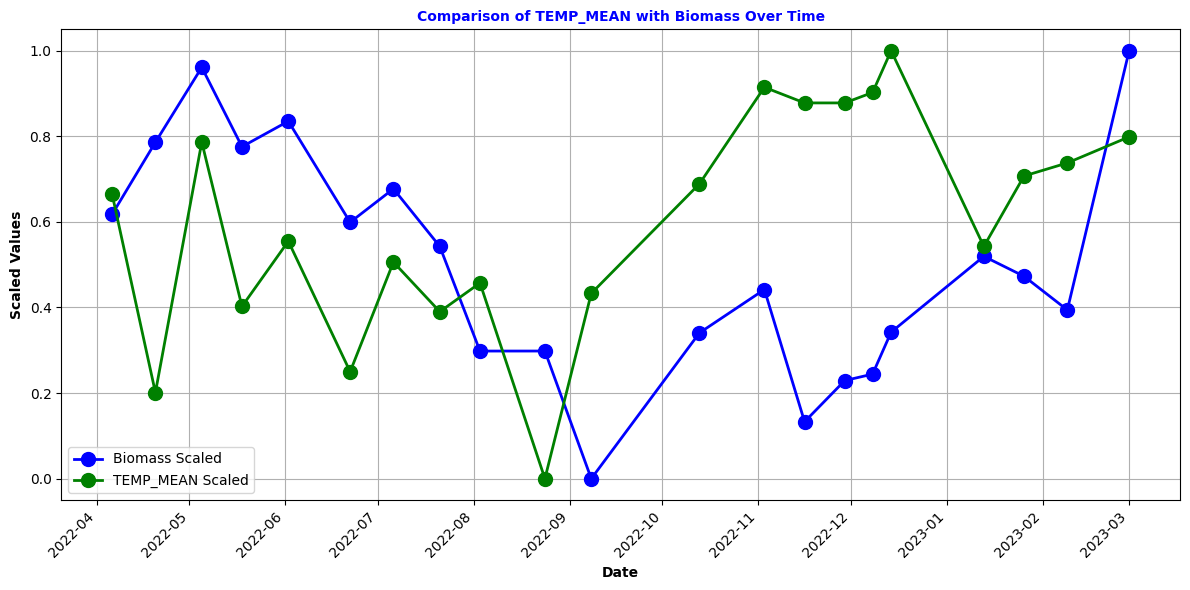

In [121]:
scale_and_plot(df, 'Biomass', 'TEMP_MEAN', f'Comparison of TEMP_MEAN with Biomass Over Time')

There is a general trend between them as in they align together, when the temperature was warmer from 2022-04, to 2022-07 the Biomass production was increased, then in the subsequent winter month, it was decreased. But then again there are a few inconsistencies in the data/plot. Especially during 2022-09 to 2023-03. This could be due to the fact that even though temperature is an integral part to the plant’s growth cycle. It could also harm or block the plant growth due to excessive heat and stress. This is the most likely reason for the decline in 2022-11 to 2022-12. In conclusion, temperature is an important part in plants as it plays an integral part in the photosynthesis of the plant, but still, its not a linear relationship between each other.

<Figure size 1200x600 with 0 Axes>

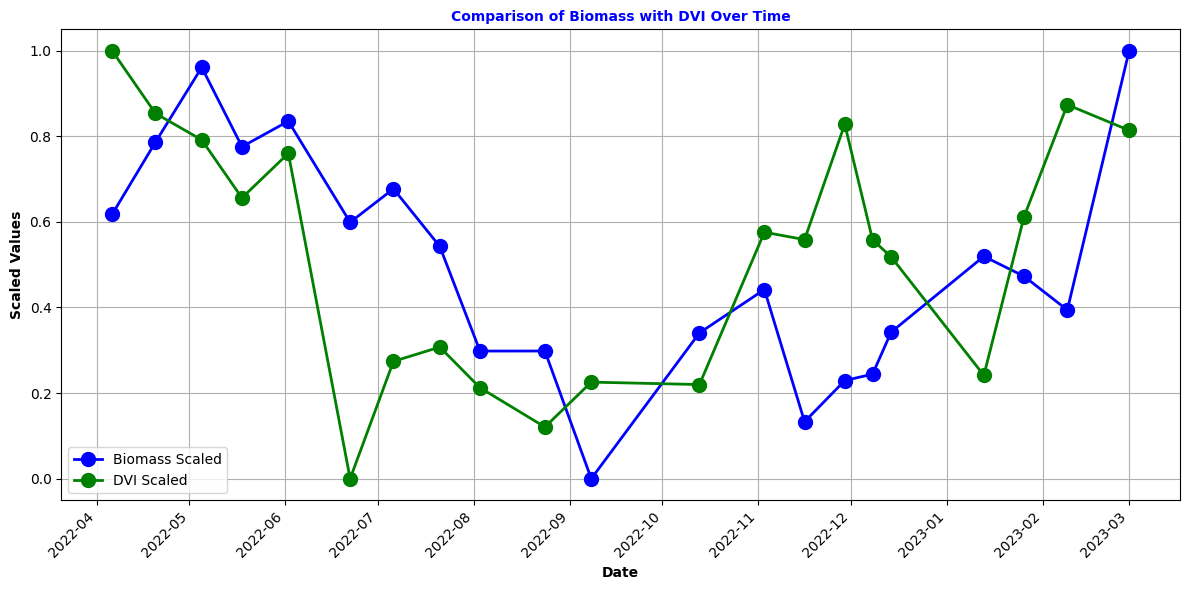

In [123]:
scale_and_plot(df, 'Biomass', 'DVI', f'Comparison of Biomass with DVI Over Time', BisWithoutAnimals=True, BisBoth=False)

The relationship between DVI and biomass seem to be the best among all of the other features, when biomass rises between 2022-10 to 2023-03, the DVI also increases. The DVI rise and fall as the biomass rise and fall. And after some digging around I found out that the DVI is calculated from the satellite images. It shows the Biomass greenness and health in general. This is just an indicator of the Biomass’s health, nothing more. It does not affect it in anyway, shape or form. In fact, the biomass affects the DVI.

<Figure size 1200x600 with 0 Axes>

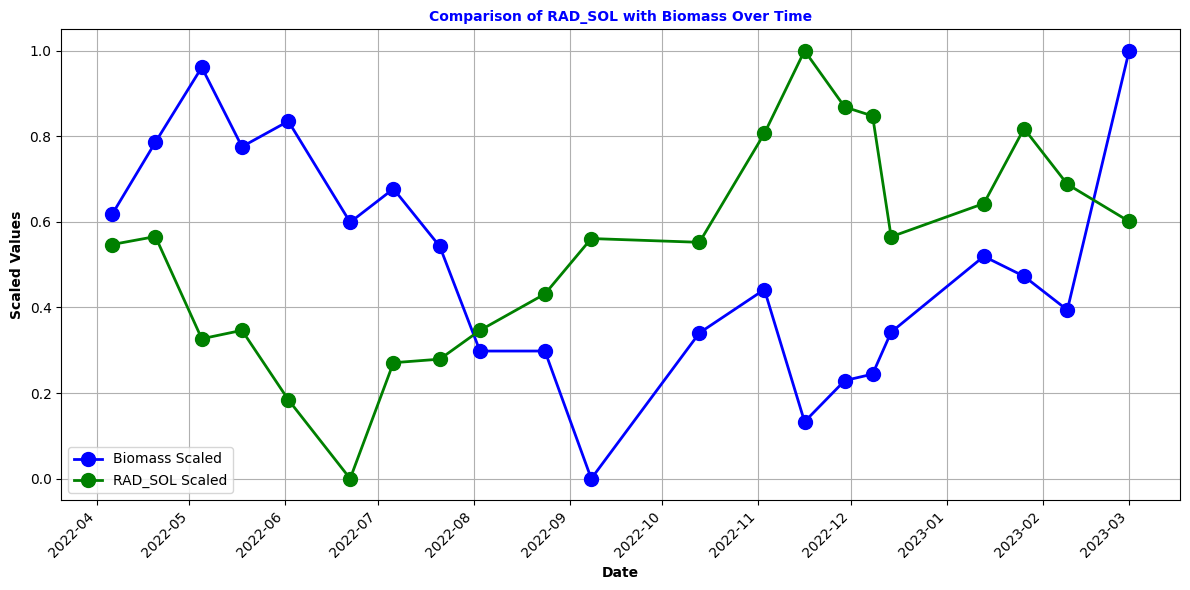

In [124]:
scale_and_plot(df, 'Biomass', 'RAD_SOL', f'Comparison of RAD_SOL with Biomass Over Time', BisWithoutAnimals=True, BisBoth=False)

Rad_SOL measures the solar radiation, which in essence measures the amount of radiation that comes from the sunlight which means that RAD_SOL also provides us insight on the amount of sun light experience in a given month. But in this graph, its shown that the RAD_SOL and biomass production are in a negative relationship. This graph gives us insights that the biomass have a specific growth cycle, meaning that even though there is enough sunlight for photosynthesis to occur 10 times. Biomass wont increase until its start its growth cycle again

<Figure size 1200x600 with 0 Axes>

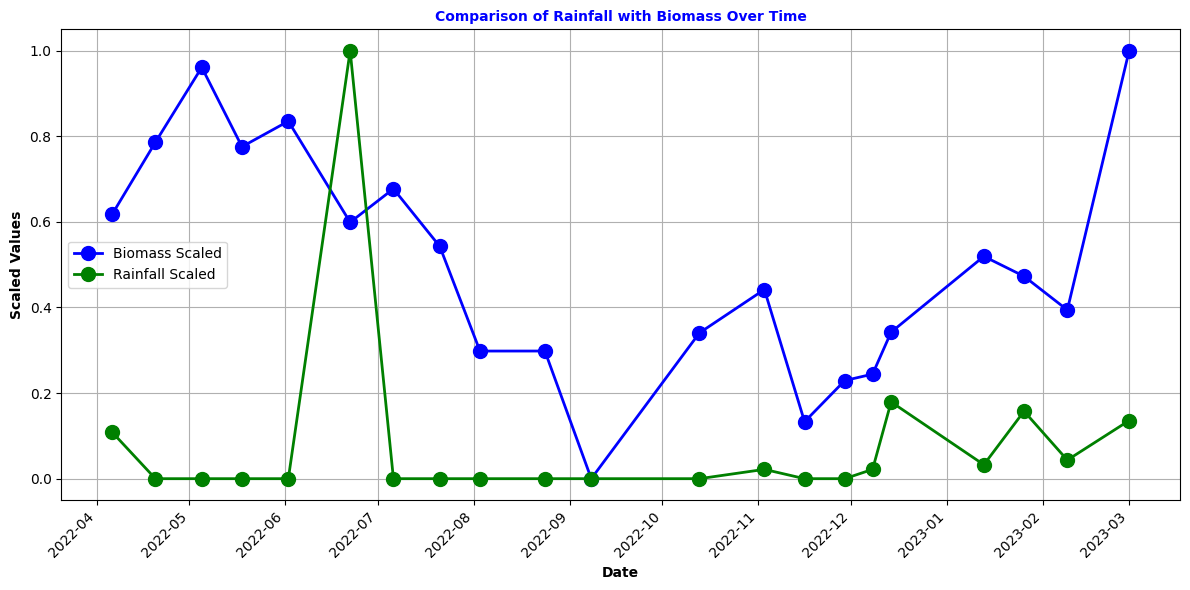

In [127]:
scale_and_plot(df, 'Biomass', 'Rainfall', f'Comparison of Rainfall with Biomass Over Time', BisWithoutAnimals=True, BisBoth=False)

And as this observation shows us, even though there was a huge amount of rainfall between 06 and 07 months, the biomass production was still decreasing, this shows us a trend that the Biomass follow a certain growth cycle. It is also shown that once there is a stable rain cycle, just not a month with a huge amount of rain, the biomass sky rocketed

<Figure size 1200x600 with 0 Axes>

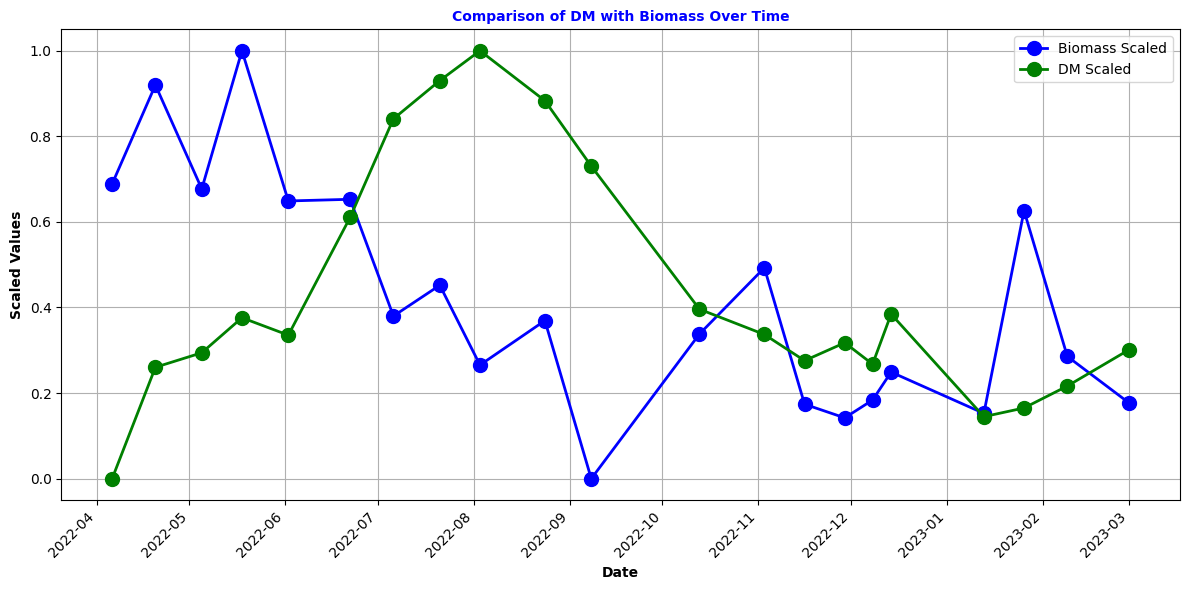

In [22]:
scale_and_plot(df, 'Biomass', 'DM', f'Comparison of DM with Biomass Over Time', BisWithoutAnimals=False, BisBoth=False)